# Pathfinder
PathFinder searches for "signatures" within graphs. Graphs being searched are directed and cyclic. Many, but not all nodes within the graph have labels. Any given node may have more than one label, and any label may be applied to more than one node. A signature is an orderd list of labels. PathFinder searches for paths between labels within the signature. PathFinder returns success if there is a path from a node with the first label in the signature that passes through  nodes with each label in order, ultimately reaching a node with the last label in the signature. Labeled nodes need not be contiguous on any given path.

---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-g -O3 -march=native -fopenmp -lgomp -lm'
Run_Parameters = '-x data/scaleData/4kx750.adj_list'
```

---
## Scaling

In [1]:
# Machine Info
Cores_per_Socket = 18
Sockets = 2
Threads_per_Core = 2
BYTES_per_CACHELINE = 64 # Bytes per Cacheline # From Documentation
CPU_MHz = 2301.0 # MHz # From lscpu or /proc/cpuinfo

# Architecture Info
IPC_Baseline_per_Core = 2
Load_Ports_per_Core = 2

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

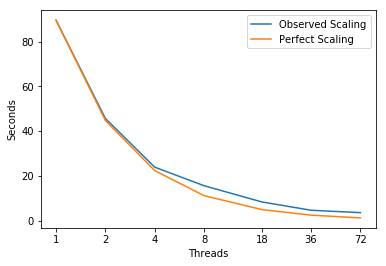

In [3]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, [89.5, 45.65, 23.9, 15.625, 8.388888888888888, 4.666666666666667, 3.597222222222222],
        label='Observed Scaling')
ax.plot(Threads, [89.5, 44.75, 22.375, 11.1875, 4.972222222222222, 2.486111111111111, 1.2430555555555556],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                            |  100.0 %   |        1.6          |         6.1% |         63.3% |      0.0% |                0.49     |       14.5% |       12.3%  |       0.0%    |
| 72                           |  100.0 %   |        1.3          |         5.6% |         61.9% |      0.0% |                0.42     |       22.4% |       19.3%  |       0.0%    |



---
## findNextLabel( )
| findNextLabel | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:--------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1             |  69.9 %   |        1.6          |         5.5% |         68.0% |      0.0% |                0.52     |       13.8% |       12.5%  |       0.0%    |
| 72            |  40.8 %   |        2.0          |         6.0% |         66.6% |      0.0% |                0.63     |       37.6% |       34.7%  |       0.0%    |
```c
138 bool findNextLabel( Node *node, Signature labels, NodePtrVec *result, Bitfield *visited ) 
139 {
140     EdgeList *edge;
141     bool success = false;
142     NodePtrVec *nextLegResult = NULL;
143     /* NodePtrVec *nextLegVisited = NULL; */
144     Bitfield *nextLegVisited = NULL;
145 
146 
147     /* A little basic error checking */
148     if ( !node || !labels || !result|| !visited )
149     {
150         return( false );
151     }
152 
153     /* If this node is already in the vector, we have found a loop. return false. */
154 
155     if ( Bitfield_nodeVisited( visited, node ) )
156         return( false );
157 
158     /* put this node on the result vector to show that we've been here */
159     NodePtrVec_push( result, node );
160 
161     /* Check this node's edges to see if there's a match */
162     /* Note: We have a NodePtrVec holding the set of nodes with this label. It
163      *       may be more optimal to see if a given edge node is in that set
164      *       rather than doing a bunch of inefficient strcmp calls. Another approach
165      *       would be to have unique hash values for each label, and thereby be
166      *       able to compare those. However for the initial version of this code,
167      *       keeping things simple and straightforward, we're doing the string
168      *       compare.
169      */
170 
```
| loop at searchAlgorithms.c: 171 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:--------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                               |  32.3 %   |        1.3          |         8.1% |         68.0% |      0.0% |                0.40     |       17.3% |       15.7%  |       0.0%    |
| 72                              |  18.0 %   |        1.6          |         8.7% |         66.7% |      0.0% |                0.48     |       46.7% |       43.2%  |       0.0%    |

```c
171     for ( edge = node->edges; edge != NULL; edge = edge->nextEdge )
172     {
173 
174         // string based:
175         if ( edge->targetNode->label && strcmp( edge->targetNode->label, labels[0] ) == 0 )
176         // index based: if ( edge->targetNode->labelIdx == labelIdxs[0] )
177         {
178             if ( labels[1] != NULL ) /* more steps in the signature */
179             {
180                 nextLegResult = NodePtrVec_new( 50 ); /* arbitrary size, malloc success checked in recursion */
181                 nextLegVisited = Bitfield_new(visited->bitsNeeded);
182 
183                 success = findNextLabel( edge->targetNode, &labels[1], nextLegResult, nextLegVisited );
184                 /* NodePtrVec_delete( nextLegVisited ); */
185                 Bitfield_delete( nextLegVisited );
186                 if ( success )
187                 {
188                     NodePtrVec_appendVectors( result, nextLegResult, true );
189                     NodePtrVec_delete( nextLegResult );
190                     return( true );
191                 }
192 
193             }
194             else /* We have exhausted the signature - ultimate victory! */
195             {
196                 /* Register this edge node as being the final node */
197                 NodePtrVec_push( result, edge->targetNode );
198                 return( true );
199             }
200         }
201     }
202 
203 
204     /* IF we made it here, we need to continue through the tree, seeing if any of our
205      * edge nodes have a connection to a labeled node.
206      */
207     for ( edge = node->edges; edge != NULL; edge = edge->nextEdge )
208     {
209         success = findNextLabel( edge->targetNode, labels, result, visited );
210         if ( success )
211             return( true ); /* this edge has a path to the ultimate signature path */
212     }
213 
214 
215     /* and, if we make it here, we have failed. */
216     NodePtrVec_pop( result ); /* take current node off the result vector */
217     return false;
218 }
```

Pathfinder scales well but does not pressure the system.  Time is spent waiting or on locks with multiple threads.  

## Parallel Waiting 
```c

        #pragma omp parallel for private(i,j) shared(graph) reduction(+:found) \
                reduction(+:searches) collapse(2)
```
what is causing the waiting?  The reductions are simple counters, probably locks on the shared graph??